#### Some of the following code was sourced from: https://www.kaggle.com/code/gulsahdemiryurek/image-classification-with-logistic-regression

## In this exercise, you will be training an image classifier that utilizes logistic regression to classify facial images as either male or female. Due to past technologies falsely classifying people of color, we are particularly concerned about our classifier functioning well for all racial groups. While our classifier has already been constructed, we need to assemble the optimal training data set for an accurate and unbiased classifier.

### To begin, we need to import all the necessary data. The data can be found here: https://github.com/lls4abt/FacialRecognitionCaseStudy/tree/master/Materials/Data

### Download both the training and testing data sets nd store them somewhere you can easily access

### Now let's start by building our classifier

#### First, import the necessary modules

In [174]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2 
import os 
from tqdm import tqdm 
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import os
import random
import shutil

#### Let's create our train_data function which prepares our training images to be run through the classifier.

In [175]:
def train_data(train_female, train_male, image_size):
    train_data_female = [] 
    train_data_male=[]
    for image1 in tqdm(os.listdir(train_female)): 
         if image1 != ".DS_Store":
            path = os.path.join(train_female, image1)
            img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
            img1 = cv2.resize(img1, (image_size, image_size))
            train_data_female.append(img1) 
    for image2 in tqdm(os.listdir(train_male)): 
        if image2 != ".DS_Store":
            path = os.path.join(train_male, image2)
            img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
            img2 = cv2.resize(img2, (image_size, image_size))
            train_data_male.append(img2) 
        
    train_data= np.concatenate((np.asarray(train_data_female),np.asarray(train_data_male)),axis=0)
    return train_data 

#### Let's create our test_data function which prepares our testing images to be run through the classifier.

In [176]:
def test_data(test_female, test_male, image_size):
    test_data_female = [] 
    test_data_male = []
    for image1 in tqdm(os.listdir(test_female)): 
        if image1 != ".DS_Store":
            path = os.path.join(test_female, image1)
            img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
            img1 = cv2.resize(img1, (image_size, image_size))
            test_data_female.append(img1) 
    for image2 in tqdm(os.listdir(test_male)): 
        if image2 != ".DS_Store":
            path = os.path.join(test_male, image2)
            img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
            img2 = cv2.resize(img2, (image_size, image_size))
            test_data_male.append(img2) 
    
    test_data= np.concatenate((np.asarray(test_data_female),np.asarray(test_data_male)),axis=0) 
    return test_data 

#### Now let's build our logistic regression classifier. The details about how this classifier works is not necessary to know, but if you'd like to learn more there are plenty of sources here: 

https://github.com/lls4abt/FacialRecognitionCaseStudy/tree/master/Materials/Articles

In [177]:
def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w, b

def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

def forward_backward_propagation(w,b,x_train,y_train):
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1]
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost,gradients

def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    
    for i in range(number_of_iterarion):
        
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 100 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list

def predict(w,b,x_test):
    
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))

    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

def logistic_regression(x_train, y_train, x_test, y_test, learning_rate, num_iterations):

    dimension =  x_train.shape[0]
    w,b = initialize_weights_and_bias(dimension)

    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)
    
    print("Test Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100,2)))
    print("Train Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100,2)))

#### Now this is where you come in. It's time to assemble our training data set. Our training set will consist of 1000 images and you will choose how many images from each racial group it will consist of. First we need to create a function that will pull images from our racial group folders. There are 4 racial groups: white, black, asian, other.

In [178]:
def select_images (source, num_images, dst_dir):
    used_images = []
    file_list = os.listdir(source)
    i = 0
    while i < num_images:
        a = random.choice(file_list)
        if a not in used_images:
            if a != ".DS_Store":
                shutil.copy(source + a, dst_dir)
                used_images.append(a)
                i+=1

#### ACTION REQUIRED: Now let's select how many images from each racial group you want to include in the training data. The default only includes white images. Make sure your total adds up to 1000. Also remember to record the final inputs. 

In [1]:
## ALTER THE FOLLOWING BASED ON HOW MANY IMAGES YOU WANT TO INCLUDE IN THE TRAINING SET FROM EACH RACIAL GROUP

number_white = 1000
number_asian = 0
number_black = 0
number_other = 0

#### ACTION REQUIRED: Now create the training set

In [180]:
## ALTER THE FOLLOWING BASED ON PATHWAYS TO WHERE YOU STORED THE DATA

dst_dir_f = "Data/Train/TrainFemale/" #this folder is already created but should be empty
dst_dir_m = "Data/Train/TrainMale/" #this folder is already created but should be empty

## The following folders should already contain images 
white_path_f = "Data/Train/WhiteFemale/" 
asian_path_f = "Data/Train/AsianFemale/"
black_path_f = "Data/Train/BlackFemale/"
other_path_f = "Data/Train/OtherFemale/"

white_path_m = "Data/Train/WhiteMale/"
asian_path_m = "Data/Train/AsianMale/"
black_path_m = "Data/Train/BlackMale/"
other_path_m = "Data/Train/OtherMale/"

for f in os.listdir(dst_dir_f):
    os.remove(os.path.join(dst_dir_f, f))
    
for f in os.listdir(dst_dir_m):
    os.remove(os.path.join(dst_dir_m, f))  

select_images(white_path_f, number_white, dst_dir_f)
select_images(asian_path_f, number_asian, dst_dir_f)
select_images(black_path_f, number_black, dst_dir_f)
select_images(other_path_f, number_other, dst_dir_f) 

select_images(white_path_m, number_white, dst_dir_m)
select_images(asian_path_m, number_asian, dst_dir_m)
select_images(black_path_m, number_black, dst_dir_m)
select_images(other_path_m, number_other, dst_dir_m)

In [181]:
## ALTER THE FOLLOWING BASED ON PATHWAYS TO WHERE YOU STORED THE DATA

test_female_data = "Data/Test/TestFemale/"
test_male_data = "Data/Test/TestMale/"

train_female_data = "Data/Train/TrainFemale/"
train_male_data = "Data/Train/TrainMale/"

#### Now let's run our classifier with the training set you constructed. Our classifier will be trained with our training data set and then it will attempt to classify the 200 test images. A final accuracy will be returned. Remember to record this final test accuracy.

100%|███████████████████████████████████████| 101/101 [00:00<00:00, 3092.38it/s]


X train flatten (1870, 16384)
X test flatten (330, 16384)
Cost after iteration 0: nan
Cost after iteration 100: 2.398853
Cost after iteration 200: 2.067858
Cost after iteration 300: 1.794276
Cost after iteration 400: 1.556494
Cost after iteration 500: 1.330636
Cost after iteration 600: 1.109059
Cost after iteration 700: 0.909988
Cost after iteration 800: 0.761304
Cost after iteration 900: 0.651378
Cost after iteration 1000: 0.565860
Cost after iteration 1100: 0.504827
Cost after iteration 1200: 0.317730
Cost after iteration 1300: 0.278412
Cost after iteration 1400: 0.269474


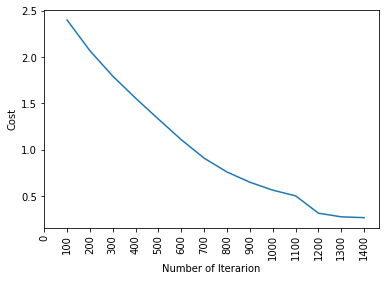

Test Accuracy: 90.0 %
Train Accuracy: 90.32 %


In [182]:
image_size = 128

train_data = train_data(train_female_data, train_male_data, image_size) 
test_data = test_data(test_female_data, test_male_data, image_size)

x_data=np.concatenate((train_data,test_data),axis=0)
x_data = (x_data-np.min(x_data))/(np.max(x_data)-np.min(x_data))

z1 = np.zeros(1000)
o1 = np.ones(1000)
Y_train = np.concatenate((o1, z1), axis=0)
z = np.zeros(100)
o = np.ones(100)
Y_test = np.concatenate((o, z), axis=0)

y_data=np.concatenate((Y_train,Y_test),axis=0).reshape(x_data.shape[0],1)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=42)
number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]

x_train_flatten = x_train.reshape(number_of_train,x_train.shape[1]*x_train.shape[2])
x_test_flatten = x_test .reshape(number_of_test,x_test.shape[1]*x_test.shape[2])
print("X train flatten",x_train_flatten.shape)
print("X test flatten",x_test_flatten.shape)

x_train = x_train_flatten.T
x_test = x_test_flatten.T
y_test = y_test.T
y_train = y_train.T

logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 0.01, num_iterations = 1500)

### Make sure to record you're test accuarcy as well as the makeup of your training set. Run your classifier several more times trying different combinations for the training data set (don't worry about resetting your training set, the code will do this for you). What training set resulted in the highest test accuracy? Why do you think this is so? Are there any pattern or trends in inputs and outputs?